# Sumaryzacja tekstu  
**Porównanie dwóch podejść do sumaryzacji tekstu: ekstrakcyjnej i abstrakcyjnej**
**dataset**: EdinburghNLP/xsum    
**model do sumaryzacji ekstrakcyjnej**: BERT large model (uncased) z pomocą biblioteki bert-extractive-summarizer  
**model do symaryzacji abstrakcyjnej**: HuggingFaceTB/SmolLM3-3B
     
autor: Tobiasz Kownacki   

## Przygotowanie wszystkich potrzebnych importów

In [1]:
%pip install -q -U transformers
%pip install -q -U datasets==3.6.0
%pip install -q -U evaluate rouge_score bert_score
%pip install -q -U tqdm
%pip install -q -U bert-extractive-summarizer
%pip install -q -U matplotlib
%pip install -q -U peft
%pip install -q -U bitsandbytes
%pip install -q -U trl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    PreTrainedTokenizer,
    PreTrainedModel,
    TrainerCallback,
    BitsAndBytesConfig,
    DataCollatorWithPadding,
)
from datasets import load_dataset
from summarizer import Summarizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import evaluate
import pandas as pd
import numpy as np
import re
from peft import LoraConfig, get_peft_model, TaskType
import copy
from trl import SFTTrainer, SFTConfig
import warnings
from pathlib import Path

warnings.filterwarnings("ignore", message="MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16")
warnings.filterwarnings("ignore", category=FutureWarning, module="torch.utils.checkpoint")

## Przygotowanie danych

In [3]:
random_state = 55
dataset = load_dataset("EdinburghNLP/xsum", trust_remote_code=True)

train_dataset = dataset["train"].shuffle(seed=random_state)
val_dataset = dataset["validation"].shuffle(seed=random_state)
test_dataset = dataset["test"].shuffle(seed=random_state)

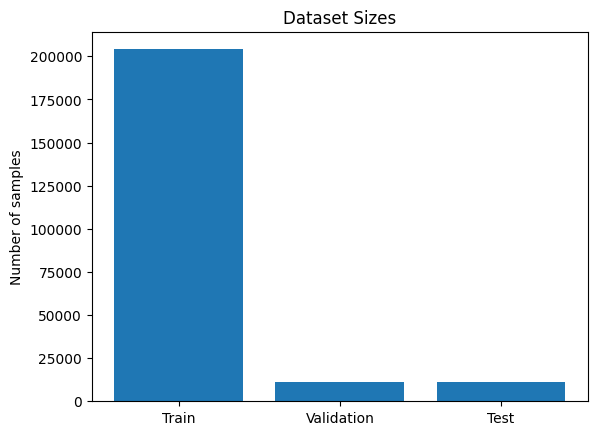

In [4]:
sizes = [len(train_dataset), len(val_dataset), len(test_dataset)]
labels = ["Train", "Validation", "Test"]
plt.bar(labels, sizes)
plt.ylabel("Number of samples")
plt.title("Dataset Sizes")
plt.show()

przykładowy element zestawu danych:

In [5]:
i = 16
dataset_item = train_dataset[i]

for key in train_dataset[i]:
    print(f"{key}: {dataset_item[key]}\n")

document: Daniel Fox, 29, from St Helens, was found with a knife wound in Westfield Street and North John Street at about 03:20 BST on Friday.
Two women, both aged 18 and from the Rainhill area, have been arrested on suspicion of assisting an offender.
One has been released on police bail and one is still being questioned.
Police said Mr Fox was attacked outside Dreem Bar where he worked, where staff described him as "a good guy and a gent".
Paying tribute, his family said he had recently become a carer for autistic children and was "an outgoing, loving and private person".

summary: A doorman who was stabbed outside a St Helens bar died as a result of a single stab wound to his body, a post-mortem examination has found.

id: 37232661



# Sumaryzacja ekstrakcyjna    
## Użycie modelu BERT

In [4]:
def generate_summaries(model: Summarizer, test_dataset: Dataset) -> list:
    generated_summaries = []
    for item in tqdm(test_dataset):
        text = item["document"]
        summary = model(text, min_length=10, use_first=False, num_sentences=1)
        generated_summaries.append(summary)

    return generated_summaries

In [5]:
bertscore = evaluate.load("bertscore")
rouge = evaluate.load("rouge")

metrics_data_list = []

def display_metrics(generated_summaries: list[str], references: list[str], step: int = None):
    rouge_results = rouge.compute(
        predictions=generated_summaries, references=references
    )

    bertscore_results = bertscore.compute(
        predictions=generated_summaries, references=references, lang="en", device="cuda"
    )

    metrics_data = {
        "Metric": [
            "ROUGE-1",
            "ROUGE-2",
            "ROUGE-L",
            "BERTScore (Precision)",
            "BERTScore (Recall)",
            "BERTScore (F1)",
        ],
        "Score": [
            rouge_results["rouge1"],
            rouge_results["rouge2"],
            rouge_results["rougeL"],
            np.mean(bertscore_results["precision"]),
            np.mean(bertscore_results["recall"]),
            np.mean(bertscore_results["f1"]),
        ],
    }

    df_display = pd.DataFrame(metrics_data)
    df_display["Score"] = df_display["Score"].apply(lambda x: round(x, 4))

    display(df_display)

    if step is not None:
        metrics_data["Step"] = step
        metrics_data_list.append(metrics_data)


## Wariant 1: Konfiguracja podstawowa (Standard Embeddings)

In [7]:
test_subset = test_dataset.select(range(1000))
bert_model = Summarizer(model="bert-large-uncased", random_state=random_state)
generated_summaries = generate_summaries(bert_model, test_subset)
references = [item["summary"] for item in test_subset]
display_metrics(generated_summaries, references)

100%|██████████| 1000/1000 [04:20<00:00,  3.83it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,Metric,Score
0,ROUGE-1,0.1694
1,ROUGE-2,0.0196
2,ROUGE-L,0.1229
3,BERTScore (Precision),0.8506
4,BERTScore (Recall),0.8594
5,BERTScore (F1),0.8548


In [8]:
# Cleanup
del generated_summaries
del bert_model
gc.collect()
torch.cuda.empty_cache()

## Wariant 2: Konfiguracja rozszerzona (Hidden Layer Concatenation)

In [7]:
bert_model = Summarizer(
    model="bert-large-uncased",
    hidden=[-1, -2],
    hidden_concat=True,
    random_state=random_state,
)
generated_summaries = generate_summaries(bert_model, test_subset)
references = [item["summary"] for item in test_subset]
display_metrics(generated_summaries, references)

100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,Metric,Score
0,ROUGE-1,0.1691
1,ROUGE-2,0.0208
2,ROUGE-L,0.1233
3,BERTScore (Precision),0.8514
4,BERTScore (Recall),0.8591
5,BERTScore (F1),0.8551


In [8]:
del generated_summaries
del bert_model
gc.collect()
torch.cuda.empty_cache()

# Sumaryzacja abstrakcyjna
### Przygotowanie tokenizera

In [7]:
base_model_id = "HuggingFaceTB/SmolLM3-3B"

tokenizer = AutoTokenizer.from_pretrained(base_model_id, use_fast=True, padding_side="left")

### Przygotowanie modelu

In [8]:
q_config = BitsAndBytesConfig(load_in_8bit=True)
model = AutoModelForCausalLM.from_pretrained(
    base_model_id, quantization_config=q_config, dtype=torch.bfloat16, device_map="auto", attn_implementation="flash_attention_2"
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.30s/it]


### Funkcje pomocnicze

In [9]:
def clean_summary(text):
    cleaned_text = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL)
    return cleaned_text.strip()


def generate_few_shot_base_messages(train_subset: Dataset) -> list[dict]:
    base_messages = [
        {
            "role": "system",
            "content": (
                "You are a professional BBC news editor. "
                "Your task is to write an extremely concise summary of the article. "
                "The summary must consist of EXACTLY ONE sentence. "
            )
        }
    ]
    for item in train_subset:
        article_text = item["document"]
        summary_text = item["summary"]
        base_messages.append(
            {
                "role": "user",
                "content": f"Article:\n{article_text}"
            }
        )
        base_messages.append(
            {
                "role": "assistant",
                "content": summary_text
            }
        )
    return base_messages


def generate_and_tokenize_test_prompt(data_point, few_shot_examples: list[dict] = None):
    article_text = data_point["document"]
    messages = generate_few_shot_base_messages(few_shot_examples or [])
    messages.append(
        {
            "role": "user",
            "content": f"Article:\n{article_text}"
        }
    )
    text_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    tokenized_prompt = tokenizer(
        text_prompt,
        add_special_tokens=False,
        padding=False,
        truncation=True,
        max_length=4096
    )
    return tokenized_prompt

### Funkcje odpowiadające za inferencje

In [10]:
def generate_text(model: PreTrainedModel, tokenizer: PreTrainedTokenizer, model_inputs, max_new_tokens: int = 200) -> str:

    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids = model_inputs['input_ids'],
            attention_mask = model_inputs['attention_mask'],
            max_new_tokens = max_new_tokens,
            num_beams = 1,
            do_sample = False,

        )
        input_len = model_inputs["input_ids"].shape[1]
        new_tokens = generated_ids[:, input_len:]
        decoded = tokenizer.batch_decode(new_tokens, skip_special_tokens=True)

        del generated_ids, new_tokens
        return decoded


def generate_summaries(
        model: PreTrainedModel,
        tokenizer: PreTrainedTokenizer,
        tokenized_dataset: Dataset,
        batch_size: int = 8
        ):

    all_summaries = []
    dataloader = torch.utils.data.DataLoader(
        tokenized_dataset,
        batch_size=batch_size,
        collate_fn=DataCollatorWithPadding(tokenizer, padding=True)
    )

    for batch in tqdm(dataloader):
        model_inputs = {key: val.to(model.device) for key, val in batch.items()}
        summaries = generate_text(model, tokenizer, model_inputs, max_new_tokens=300)
        all_summaries.extend([clean_summary(s) for s in summaries])

    del model_inputs
    torch.cuda.empty_cache()
    gc.collect()

    return all_summaries

## Zero-shot prompting

In [15]:
%%time

tokenized_data_set = test_subset.map(generate_and_tokenize_test_prompt, remove_columns=test_subset.column_names)
generated_summaries_v1 = generate_summaries(
    model, tokenizer, tokenized_data_set, batch_size=16
)
references = [item["summary"] for item in test_subset]
display_metrics(generated_summaries_v1, references)

# Cleanup
del generated_summaries_v1
gc.collect()
torch.cuda.empty_cache()
# for summary, item in zip(generated_summaries_v1, test_subset):
#     print(f"Article: {item['document']}\nSummary: {summary}\nPerfect Summary:\n {item['summary']}\n\n")

  0%|          | 0/63 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


100%|██████████| 63/63 [32:15<00:00, 30.72s/it]


,Metric,Score
0,ROUGE-1,0.2359
1,ROUGE-2,0.0559
2,ROUGE-L,0.1654
3,BERTScore (Precision),0.8552
4,BERTScore (Recall),0.8870
5,BERTScore (F1),0.8707


CPU times: user 32min 7s, sys: 403 ms, total: 32min 7s
Wall time: 32min 22s


## Five-shot prompting

In [11]:
%%time

tokenized_data_set = test_subset.map(
    lambda x: generate_and_tokenize_test_prompt(
        x, few_shot_examples=train_dataset.select(range(5))
    ), remove_columns=test_subset.column_names
)
generated_summaries_v2 = generate_summaries(
    model, tokenizer, tokenized_data_set, batch_size=16
)
references = [item["summary"] for item in test_subset]
display_metrics(generated_summaries_v2, references)

# Cleanup
del generated_summaries_v2
gc.collect()
torch.cuda.empty_cache()
# for summary, item in zip(generated_summaries_v2, test_subset):
#     print(f"Article: {item['document']}\nSummary: {summary}\nPerfect Summary:\n {item['summary']}\n\n")

100%|██████████| 63/63 [18:33<00:00, 17.67s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,Metric,Score
0,ROUGE-1,0.2917
1,ROUGE-2,0.0854
2,ROUGE-L,0.2158
3,BERTScore (Precision),0.8820
4,BERTScore (Recall),0.8904
5,BERTScore (F1),0.8861


CPU times: user 18min 37s, sys: 2.47 s, total: 18min 39s
Wall time: 18min 50s


## Dostrojenie modelu do zadania sumaryzacji na zbiorze treningowym za pomocą metody LoRA
### Funkcje pomocnicze

In [13]:
def generate_train_prompt(data_point):
    article_text = data_point["document"]
    summary_text = data_point["summary"]
    return {
        "prompt": [
            {
            "role": "system",
            "content": (
                "You are a professional BBC news editor. "
                "Your task is to write an extremely concise summary of the article. "
                "The summary must consist of EXACTLY ONE sentence. "
            )
        },{
            "role": "user",
            "content": f"Article:\n{article_text}"
        }
        ],
        "completion": [{
            "role": "assistant",
            "content": f"{summary_text}"
        }]
    }

## Przygotowanie datasetów pod trening

In [ ]:
train_subset = train_dataset.select(range(5000))
val_subset = val_dataset.select(range(500))

lora_train = train_subset.map(generate_train_prompt, remove_columns=train_subset.column_names)
lora_val = val_subset.map(generate_train_prompt, remove_columns=val_subset.column_names)

## Konfiguracja dostrojenia

In [15]:
config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules="all-linear",
    bias="none",
    lora_dropout=0.05,
    task_type=TaskType.CAUSAL_LM
)
peft_model = get_peft_model(copy.deepcopy(model), config)
peft_model.print_trainable_parameters()

trainable params: 15,114,240 || all params: 3,090,212,864 || trainable%: 0.4891


## CallBack do liczenia metryk po N krokach

In [16]:
class GenerativeMetricsCallback(TrainerCallback):
    def __init__(self, eval_dataset, tokenizer, num_samples=20, batch_size=4, metric_eval_steps = 200):
        eval_dataset = eval_dataset.select(range(min(num_samples, len(eval_dataset))))
        self.tokenized_dataset = eval_dataset.map(generate_and_tokenize_test_prompt, remove_columns=eval_dataset.column_names)
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.reference_texts = [item["summary"] for item in eval_dataset]
        self.metric_eval_steps = metric_eval_steps
    def on_evaluate(self, args, state, control, model=None, **kwargs):
        print(f"\n Metrics after {state.global_step} steps")

        if model is None:
            return

        model.config.use_cache = True
        self.tokenizer.padding_side = "left"
        generated_texts = generate_summaries(
            model, self.tokenizer, self.tokenized_dataset, batch_size=self.batch_size
        )

        display_metrics(generated_texts, self.reference_texts, state.global_step)

        del generated_texts
        torch.cuda.empty_cache()
        gc.collect()

        model.config.use_cache = False
        model.train()

## Konfiguracja treningu

In [17]:
output_dir = "./smollm3-3b-lora-xsum"
report_to = "none"

peft_training_args = SFTConfig(
    output_dir=output_dir,
    learning_rate=1e-4,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    warmup_steps=10,
    bf16=True,
    optim="paged_adamw_8bit",
    logging_dir="./logs",
    logging_steps=80,
    eval_strategy="steps",
    eval_steps=50,
    load_best_model_at_end=True,
    report_to=report_to,
    assistant_only_loss=True,
    dataset_text_field="text",
)

In [ ]:
my_metric_callback = GenerativeMetricsCallback(
    eval_dataset=val_subset,
    tokenizer=tokenizer,
    num_samples=500,
    batch_size=16
)

trainer = SFTTrainer(
    model=peft_model,
    train_dataset=lora_train,
    eval_dataset=lora_val,
    args=peft_training_args,
    callbacks=[my_metric_callback],
)

peft_model.config.use_cache = False
trainer.train()
peft_model.config.use_cache = True

Map: 100%|██████████| 500/500 [00:00<00:00, 733.61 examples/s]
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 128012}.


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
50,No log,1.544560,2.062758,224690.000000,0.621251
100,1.672600,1.530259,2.037253,440799.000000,0.626621
150,1.672600,1.520840,2.037382,654433.000000,0.626074
200,1.497300,1.512835,2.067607,864605.000000,0.626861
250,1.539600,1.507523,2.029115,1089404.000000,0.627504
300,1.539600,1.501226,2.024380,1303137.000000,0.629253
350,1.508200,1.497134,2.055478,1524421.000000,0.629654
400,1.489700,1.496454,2.044235,1739591.000000,0.628111
450,1.489700,1.489466,2.057781,1959162.000000,0.628455
500,1.488600,1.487298,2.053435,2175023.000000,0.631672



 Metrics after 50 steps


100%|██████████| 32/32 [04:10<00:00,  7.82s/it]


,Metric,Score
0,ROUGE-1,0.3311
1,ROUGE-2,0.1202
2,ROUGE-L,0.2646
3,BERTScore (Precision),0.9039
4,BERTScore (Recall),0.8898
5,BERTScore (F1),0.8966



 Metrics after 100 steps


100%|██████████| 32/32 [04:12<00:00,  7.89s/it]


,Metric,Score
0,ROUGE-1,0.3423
1,ROUGE-2,0.1303
2,ROUGE-L,0.2773
3,BERTScore (Precision),0.9052
4,BERTScore (Recall),0.8925
5,BERTScore (F1),0.8987



 Metrics after 150 steps


100%|██████████| 32/32 [04:26<00:00,  8.34s/it]


,Metric,Score
0,ROUGE-1,0.3440
1,ROUGE-2,0.1272
2,ROUGE-L,0.2765
3,BERTScore (Precision),0.9055
4,BERTScore (Recall),0.8938
5,BERTScore (F1),0.8995



 Metrics after 200 steps


100%|██████████| 32/32 [04:22<00:00,  8.21s/it]


,Metric,Score
0,ROUGE-1,0.3427
1,ROUGE-2,0.1297
2,ROUGE-L,0.2747
3,BERTScore (Precision),0.9050
4,BERTScore (Recall),0.8946
5,BERTScore (F1),0.8997



 Metrics after 250 steps


100%|██████████| 32/32 [05:05<00:00,  9.55s/it]


,Metric,Score
0,ROUGE-1,0.3443
1,ROUGE-2,0.1297
2,ROUGE-L,0.2795
3,BERTScore (Precision),0.9052
4,BERTScore (Recall),0.8943
5,BERTScore (F1),0.8996



 Metrics after 300 steps


100%|██████████| 32/32 [04:28<00:00,  8.38s/it]


,Metric,Score
0,ROUGE-1,0.3515
1,ROUGE-2,0.1331
2,ROUGE-L,0.2801
3,BERTScore (Precision),0.9055
4,BERTScore (Recall),0.8951
5,BERTScore (F1),0.9002



 Metrics after 350 steps


100%|██████████| 32/32 [04:32<00:00,  8.51s/it]


,Metric,Score
0,ROUGE-1,0.3485
1,ROUGE-2,0.1309
2,ROUGE-L,0.2794
3,BERTScore (Precision),0.9042
4,BERTScore (Recall),0.8957
5,BERTScore (F1),0.8999



 Metrics after 400 steps


100%|██████████| 32/32 [04:10<00:00,  7.82s/it]


,Metric,Score
0,ROUGE-1,0.3508
1,ROUGE-2,0.1318
2,ROUGE-L,0.2811
3,BERTScore (Precision),0.9064
4,BERTScore (Recall),0.8950
5,BERTScore (F1),0.9006



 Metrics after 450 steps


100%|██████████| 32/32 [04:22<00:00,  8.19s/it]


,Metric,Score
0,ROUGE-1,0.3580
1,ROUGE-2,0.1348
2,ROUGE-L,0.2844
3,BERTScore (Precision),0.9058
4,BERTScore (Recall),0.8974
5,BERTScore (F1),0.9015



 Metrics after 500 steps


100%|██████████| 32/32 [04:59<00:00,  9.35s/it]


,Metric,Score
0,ROUGE-1,0.3518
1,ROUGE-2,0.1326
2,ROUGE-L,0.2829
3,BERTScore (Precision),0.9073
4,BERTScore (Recall),0.8955
5,BERTScore (F1),0.9012



 Metrics after 550 steps


100%|██████████| 32/32 [04:14<00:00,  7.95s/it]


,Metric,Score
0,ROUGE-1,0.3514
1,ROUGE-2,0.1346
2,ROUGE-L,0.2839
3,BERTScore (Precision),0.9065
4,BERTScore (Recall),0.8964
5,BERTScore (F1),0.9013



 Metrics after 600 steps


100%|██████████| 32/32 [05:02<00:00,  9.45s/it]


,Metric,Score
0,ROUGE-1,0.3561
1,ROUGE-2,0.1361
2,ROUGE-L,0.2863
3,BERTScore (Precision),0.9059
4,BERTScore (Recall),0.8963
5,BERTScore (F1),0.9010


## Wykresy

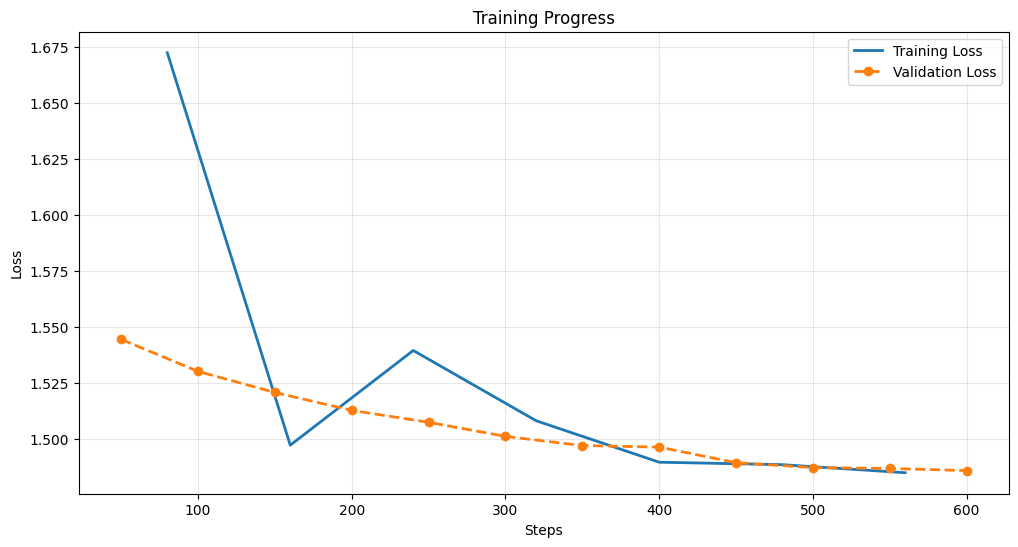

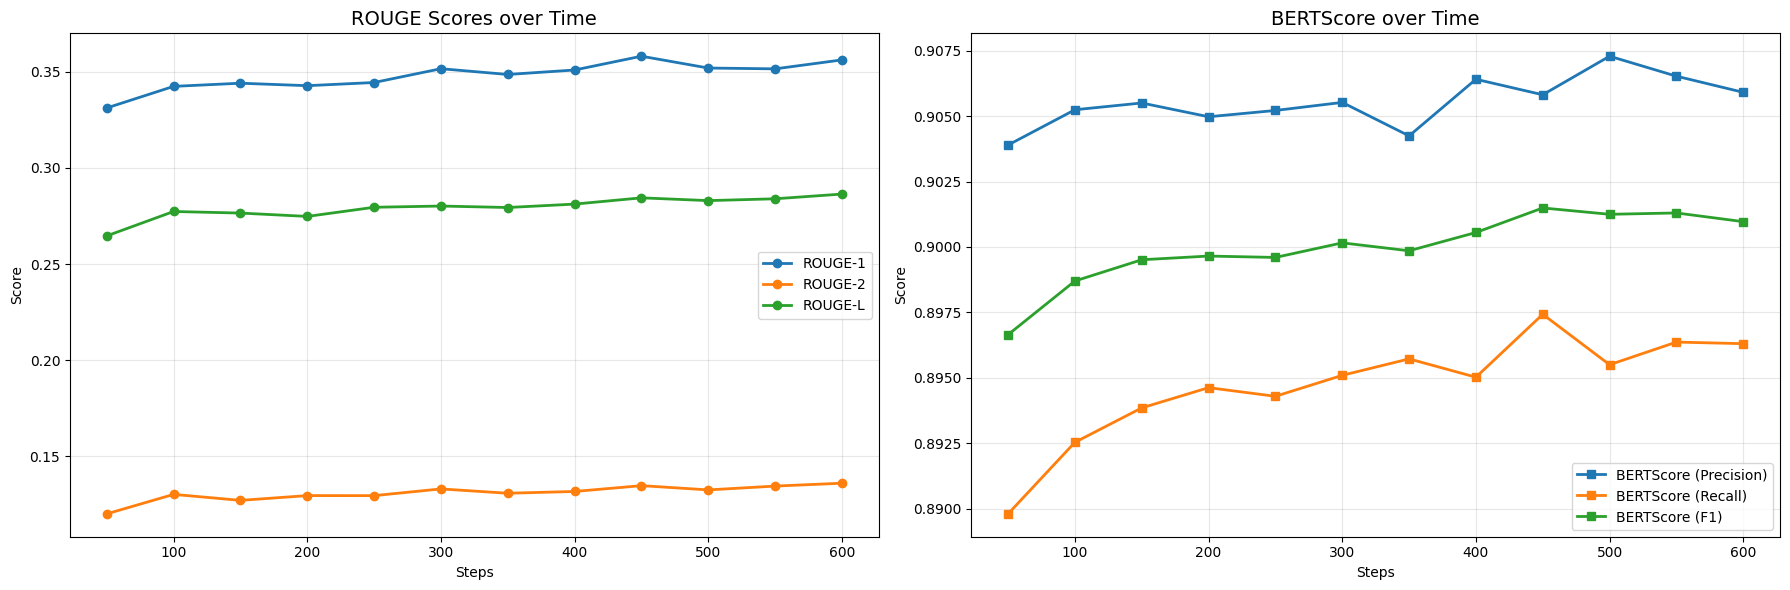

In [ ]:
def plot_from_trainer(trainer, output_dir="./plots"):

    Path(output_dir).mkdir(exist_ok=True)

    log_history = trainer.state.log_history

    train_loss = [x['loss'] for x in log_history if 'loss' in x]
    train_steps = [x['step'] for x in log_history if 'loss' in x]
    eval_loss = [x['eval_loss'] for x in log_history if 'eval_loss' in x]
    eval_steps = [x['step'] for x in log_history if 'eval_loss' in x]

    plt.figure(figsize=(12, 6))
    plt.plot(train_steps, train_loss, label='Training Loss', linewidth=2)
    if eval_loss:
        plt.plot(eval_steps, eval_loss, label='Validation Loss',
                 linewidth=2, linestyle='--', marker='o')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{output_dir}/loss.png", dpi=300, bbox_inches='tight')
    plt.show()


def plot_generative_metrics(metrics_list, output_dir="./plots"):
    Path(output_dir).mkdir(exist_ok=True, parents=True)

    flattened_data = []
    for entry in metrics_list:
        step = entry["Step"]
        step_dict = {metric: score for metric, score in zip(entry["Metric"], entry["Score"])}
        step_dict["Step"] = step
        flattened_data.append(step_dict)

    df = pd.DataFrame(flattened_data).sort_values("Step")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    rouge_cols = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
    for col in rouge_cols:
        if col in df.columns:
            ax1.plot(df["Step"], df[col], label=col, marker='o', linewidth=2)

    ax1.set_title("ROUGE Scores over Time", fontsize=14)
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Score")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    bert_cols = ["BERTScore (Precision)", "BERTScore (Recall)", "BERTScore (F1)"]
    for col in bert_cols:
        if col in df.columns:
            ax2.plot(df["Step"], df[col], label=col, marker='s', linewidth=2)

    ax2.set_title("BERTScore over Time", fontsize=14)
    ax2.set_xlabel("Steps")
    ax2.set_ylabel("Score")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/generative_metrics.png", dpi=300, bbox_inches='tight')
    plt.show()

plot_from_trainer(trainer)
plot_generative_metrics(metrics_data_list)

## Ostateczne wyniki dla dostrojonego modelu

In [ ]:
tokenized_data_set = test_subset.map(generate_and_tokenize_test_prompt, remove_columns=test_subset.column_names)
generated_summaries_v1 = generate_summaries(
    peft_model, tokenizer, tokenized_data_set, batch_size=16
)
references = [item["summary"] for item in test_subset]
display_metrics(generated_summaries_v1, references)

100%|██████████| 63/63 [09:50<00:00,  9.38s/it]


,Metric,Score
0,ROUGE-1,0.3615
1,ROUGE-2,0.1416
2,ROUGE-L,0.2891
3,BERTScore (Precision),0.9088
4,BERTScore (Recall),0.8980
5,BERTScore (F1),0.9032
